# C4021 - Group 4.2 
## Project work Weeks 7-9
### Participants

| Student Name   |   Id    |
|----------|:-------------:|
| Michel DANJOU |  18263461 |
| Brian PARLE | |
| Gerry KERLEY | |
| Gana SUBRAMANIAN | |


## Machine Learning Algorithm: Baysian Classifier
Source: http://scikit-learn.org/stable/modules/naive_bayes.html


## Dataset Information

_Source:_ https://www.kaggle.com/blastchar/telco-customer-churn

**Content**

Each row represents a customer, each column contains customer attributes described in the column Metadata.

The data set includes information about:

  *  Customers who left within the last month – the column is called Churn
  *  Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
  *  Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
  *  Demographic info about customers – gender, age range, and if they have partners and dependents

The raw data contains **7043 rows (customers) and 21 columns (features)**. 

List of features:
customerID, gender,	SeniorCitizen, Partner, Dependents,	tenure,	PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup,	DeviceProtection, TechSupport, StreamingTV,	StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges,	TotalCharges

The label is the Churn.


**Inspiration**
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]



## Notebook Structure

1. Data Loading and Pre-processing
1. Model training and testing
1. Model graphing
1. Model analysis: further eaxamination of significant features etc.


## Team Contributions:
**Training data**
  * Michel Danjou

**Pre-processing**
  * Michel Danjou

**Algorithm training and evaluation**
  * Michel Danjou

**Visualisation of outputs**
  * Michel Danjou


# Data loading

In [1]:
%reset
%matplotlib inline
%config IPCompleter.greedy=True

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplotlib
import pandas as pd
import enum 

df = pd.read_csv('telco.csv')
df.head()


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Preprocessing

## Handling Outliers
1. Start by identifying the features that can be used in a box plot.
1. Plot the columns containing numerical values to identify outliers

In [2]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


Feature with number: SeniorCitizen


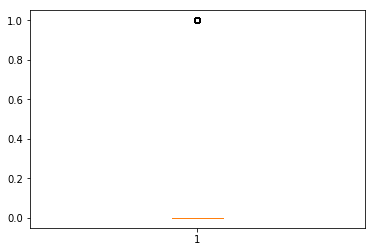


Feature with number: tenure


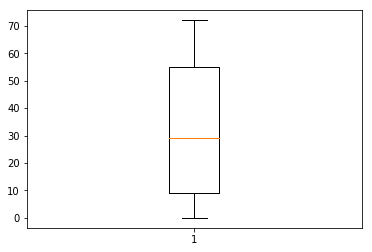


Feature with number: MonthlyCharges


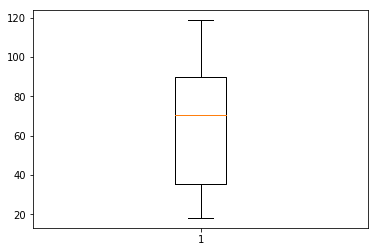

In [3]:
features_with_numbers = ['SeniorCitizen', 'tenure', 'MonthlyCharges']

for i in range(0, len(features_with_numbers)):
    print("\nFeature with number:", features_with_numbers[i])
    plt.boxplot(df[features_with_numbers[i]])
    plt.show()

## Investigating the SeniorCitizen feature
We notice that the SeniorCitizen boxplot has no box, nor whiskers. This is because the data in that column are mainly zeros with a few ones.

In [ ]:
df.hist(column="SeniorCitizen")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19bb731a20>]],
      dtype=object)

## Investigating the TotalCharges feature

Although, the TotalCharges appears to be numbers, they are showing as Object in the output of ```df.dtypes```. We need to figure out why.

In [ ]:
print(df['TotalCharges'].to_string())

Scanned the first 3000 rows and noticed that some entries at index **488, 753, 936, 1082, 1340** have no TotalCharges field.

Since the dataset is quite large, we devise a way to automatically identify non-numeric values.

We decide to print the entire row to see if we can find a justification for the lack of TotalCharges.

In [ ]:
def find_non_numeric_values(data, feature_name):
    index_errors = []
    for i in range (0,len(data[feature_name])):
        value = data.iloc[i][feature_name]
        try:
            float(value)
        except ValueError:
            index_errors.append(i)
    return index_errors

index_errors = find_non_numeric_values(df, 'TotalCharges')
print("index_errors:",index_errors)

for i in range (0, len(index_errors)):
    idx = index_errors[i]
    print("="*80)
    print(df.iloc[idx])
    

We notice that there is **no TotalCharges for each customer with a tenure of 0**. This makes sens since customers who have just joined might not have paid anything yet and might still be able to cancel"churn out".
**We can safely replace all the TotalCharges with 0**

In [ ]:
# Replacing empty TotalCharges cells with zero.
for i in range (0, len(index_errors)):
    idx = index_errors[i]
    df.at[idx, 'TotalCharges']=0
    print("="*80)
    print(df.iloc[idx])

We can now change the type of the column to **float64** so that the boxplot can be calculated.

### Important
The original dataset contained no outliers, so we have added one.

The aim of the code below is to identify it.


In [ ]:

df['TotalCharges'] = df['TotalCharges'].apply(pd.to_numeric, errors='coerce')
df.dtypes

plt.boxplot(df['TotalCharges'])
plt.show()

The boxplot shows an outlier for the TotalCharge.
We use the Tukey approach to extract the value of the outlier. More on Tukey: https://github.com/aprilypchen/depy2016/blob/master/DePy_Talk.ipynb

The ```np.percentile()``` api is new to us. Here its definition according to https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.percentile.html. Given a vector V of length N, the q-th percentile of V is the value q/100 of the way from the minimum to the maximum in a sorted copy of V.

IQR is also a new concept and represents the interquartile range (IQR), also called the midspread or middle 50%

In [ ]:
"""
Disclaimer: The code below was heavily inspired by April Chen's Tukey IQR.(see link above)
Below is my own rewrite of it.
"""
def find_outliers(x):
    # Given a vector V of length N, the q-th percentile of V is the value q/100 of the 
    # way from the minimum to the maximum in a sorted copy of V.
    q1 = np.percentile(x, 25)
    q3 = np.percentile(x, 75)
    iqr = q3-q1 
    print("q1:{}, q3:{}, iqr:{}".format(q1, q3, iqr))
    
    # Create boundaries outside which we will find the outliers
    bottom_boundary = q1 - 1.5*iqr
    bottom_outlier_indices = list(x.index[(x < bottom_boundary)])
    bottom_outlier_values = list(x[bottom_outlier_indices])
   
    top_boundary = q3 + 1.5*iqr
    top_outlier_indices = list(x.index[(x > top_boundary)])
    top_outlier_values = list(x[top_outlier_indices])

    return bottom_outlier_indices, bottom_outlier_values, top_outlier_indices, top_outlier_values

bottom_outlier_indices, bottom_outlier_values, top_outlier_indices, top_outlier_values = \
find_outliers(df['TotalCharges'])


print("bottom_outlier_indices:{}".format(bottom_outlier_indices))
print("bottom_outlier_values :{}".format(bottom_outlier_values))
print("top_outlier_indices   :{}".format(top_outlier_indices))
print("top_outlier_values    :{}".format(top_outlier_values))
      



The entry at index 7043 contains an outlier with a TotalCharges value of 99999,9
This is the outlier that we have introduced in the first place as an extra challenge. 
We can safely remove this row.


In [ ]:
print("df.shape before: ", df.shape)
df.drop(df.index[7043], inplace=True)
print("df.shape after : ", df.shape)


## Convert the feature strings to numeric values.
Use the LabelEncoder to normalize feature values.

In [ ]:
from sklearn import preprocessing

header_list = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


def encode_dataframe(df, header_list, encoder_dict):
    for header in header_list:
        #print(header)
        #print(df[header])
        le = preprocessing.LabelEncoder()
        # Update the dataframe with its encoded values
        df[header] = le.fit_transform(df[header])
        # Saving the encoder for later in case we need to decode the values
        encoder_dict[header] = le
    return df

encoder_dict = {}

df = encode_dataframe(df, header_list, encoder_dict)
df.head()



## Removing low information columns
The customerID feature can be removed as it contains no information that might help the Baysian classifier.

In [ ]:
df = df.drop(['customerID'], axis=1)
df.head()


## Separating features and labels

In [ ]:
feature_names = df.dtypes.index[:-1]
target_names = df.dtypes.index[-1]

data = df.iloc[:, :-1].values # Drop the last column
target = df.iloc[:,-1].values # Keep the last column

print("Feature names:", feature_names)
print("Target names :", target_names)

print("\nFeature shape:", data.shape)
print("Target shape :", target.shape)

## Scaling
Scaling the data.

In [ ]:
class Scaler(enum.Enum):
    STANDARD_SCALER = 1
    MIN_MAX = 2
    NONE = 3
    
    
def scale_data(scaler_name, data):
    """
    Normalising the data. 2 normalisations supported
        Standard_scaler: normalised values have a mean of 0 and std. dev. of 1
        Min max scaler: normalised values are between 0 and 1            
    """

    print("Scaler:", scaler_name)
    
    if scaler_name is Scaler.STANDARD_SCALER:
        scaler = StandardScaler()
        scaler.fit(data)
        data = scaler.transform(data)
            
    elif scaler_name is Scaler.MIN_MAX:
        scaler = MinMaxScaler()
        scaler.fit(data)
        data = scaler.transform(data)
            
    elif scaler_name is Scaler.NONE:
        pass
    
    return data

scaler_name = Scaler.MIN_MAX    
data = scale_data(scaler_name, data)


## Split between training and testing data
Here we split our testing and training data. 
  * 70% for training
  * 30% for testing

In [ ]:
training_vs_testing_ratio = 0.7

nb_rows, nb_cols = np.shape(data)
nb_training_rows = (int)(nb_rows * training_vs_testing_ratio)
nb_test_rows = nb_rows - nb_training_rows

training_dataset = data[:nb_training_rows, ]
testing_dataset = data[nb_training_rows:,]

training_labels = target[:nb_training_rows, ]
testing_labels = target[nb_training_rows:, ]

print("training_dataset shape:{}",training_dataset.shape)            
print("testing_dataset shape :{}",testing_dataset.shape)

print("\ntraining_labels shape :{}",training_labels.shape)
print("testing_labels shape  :{}",testing_labels.shape)

print("\ntesting_labels        :{}",testing_labels)


# Model training and evaluation

## Training

Here we use the Gaussian Naive Bayes (GaussianNB) algorithm.

http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [ ]:
gnb = GaussianNB()            
gnb.fit(training_dataset, training_labels)


## Testing the estimator accuracy
In the code below we run the Baysian estimator using the ```predict()``` APIs, and we review the accuracy of estimator's output using a ``for loop ``

We later found out about a feature from the Baysian API that provide similar information, namely the ```score()``` API. We kept the original ```for loop``` to show how we initially tackled the search for mismatches.

In [ ]:
def run_prediction(clf, testing_dataset):
    error_features = []
    error_labels = []
    error_index = []
    np_error_features = []
    
    results = clf.predict(testing_dataset)
    
    for i in range(0, nb_test_rows):
        if results[i] != testing_labels[i]:
            error_features.append(testing_dataset[i, :].tolist())
            error_labels.append(results[i])
            error_index.append(i)

            #print("Index:{}, incorrect match for:{}, expected label:{}, actual label:{}".format(i, testing_dataset[i], testing_labels[i], results[i]))

            # Convert the list to a np.array so that we can slice it at step 5 for plotting.
            np_error_features = np.array(error_features)

            # Metrics
            error_percentage =  (len(error_index) / nb_test_rows) * 100
            accuracy_percentage = 100 - error_percentage 
        
    metrics = dict()
    metrics['error_features'] = error_features
    metrics['error_labels'] = error_labels
    metrics['error_index'] = error_index
    metrics['nb_samples'] = nb_test_rows
    metrics['nb_errors'] = len(error_index)
    metrics['pct_errors'] = error_percentage
    metrics['pct_accuracy'] = accuracy_percentage
    metrics['results'] = results
    return metrics

metrics = run_prediction(gnb, testing_dataset)
results = metrics['results']
print("nb samples:", metrics['nb_samples'])
print("nb errors :", metrics['nb_errors'])
print("% errors  :", metrics['pct_errors'])
print("% accuracy:", metrics['pct_accuracy'])
    

In [ ]:
# Alternatively we could use the score() API to learn about the accuracy of the Naive Baysian algorithm.
# The advantage of the previous approach is that we collect information regarding the errors. 
# These will be plotted later on

score = gnb.score(testing_dataset, testing_labels, sample_weight=None)
print("Score            :", score)

## Cross validation
Sources:
  * https://stackoverflow.com/questions/16379313/how-to-use-the-a-k-fold-cross-validation-in-scikit-with-naive-bayes-classifier-a
  * http://scikit-learn.org/stable/modules/cross_validation.html
  * https://www.youtube.com/watch?v=L_dQrZZjGDg
        
        
With Cross Validation, the data are split between training and testing data in a random way. 
This limits the bias that might be present in the dataset.

In [ ]:
def do_cross_validation(data, target):
    cv = ShuffleSplit(n_splits=25, test_size=0.3, random_state=0)
    gaussian_nb = GaussianNB()            

    scores = cross_val_score(gaussian_nb, data, target, cv=cv) 
    print("Scores", scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    return scores

scores = do_cross_validation(data, target)


In [ ]:
plt.plot(scores, 'bo')
plt.ylabel("GaussianNB score")
plt.xlabel("split number")
plt.title("Accuracy of Baysian estimator over the number of split")
plt.show()

plt.hist([scores], label=['scores'])
plt.legend(loc='upper right')
plt.ylabel("Frequency")
plt.xlabel("GaussianNB score")
plt.title("Accuracy of Baysian estimator over the number of split")
plt.show()

## Changing parameters to improve the accuracy of estimator

### Using the Standard Scaler
Here we repeat our experiment using the Standard Scaler.


In [ ]:
std_scaled_data = scale_data(Scaler.STANDARD_SCALER, data)
scores_with_standard_scaler = do_cross_validation(std_scaled_data, target)
plt.hist([scores, scores_with_standard_scaler], 25, label=['scores', 'score_with_min_max_scaler', 'scores_with_standard_scaler'])
plt.legend(loc='upper right')
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Comparing Min_Max and Standard scaler impact on Baysian accuracy")
plt.show()


After reviewing the data, it appears that the Min_Max and Standard Scaler are absolutely equivalent in terms of impact on the accuracy of the estimator as they have the **exact same score.** of **75%**

### Using Primary Component Analysis
In the code below, we change number of components used by PCA and run cross validation on the estimator.  

In [ ]:
min_nb_component = 1
max_nb_component = 10
mean_accuracy_results = []

for nb_component in range (min_nb_component, max_nb_component):
    print("Nb component:", nb_component)

    pca = PCA(nb_component)
    data_pca = pca.fit_transform(data)
    mean_accuracy_results.append(do_cross_validation(data_pca, target).mean())

print("mean_accuracy_results")


plt.hist([mean_accuracy_results], 25, label=['mean_accuracy_results'])
plt.legend(loc='upper right')
plt.xlabel("accuracy")
plt.ylabel("frequency")
plt.title("Impact of PCA on Baysian accuracy")
plt.show()



Observations regarding the PCA.
  * introducing the PCA only increased the accuracy by 0.2% (nb_components=2)
  

# Model graphing

# Scatter plot
Generate a scatter plot of the initial data reduced with PCA(nb_component=2)

In [ ]:
pca = PCA(2)
training_data_pca = pca.fit_transform(training_dataset)
testing_data_pca = pca.fit_transform(testing_dataset)
print("testing_dataset.shape:", testing_data_pca.shape)

colors = ['red','green','blue','purple']

plt.scatter(testing_data_pca[:, 0], testing_data_pca[:, 1], c=testing_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.legend()
plt.grid(True)
plt.show()

## ROC curve

In [ ]:
from sklearn import preprocessing

def encode_labels(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    encoded_labels = le.transform(labels) 
    return encoded_labels

print("testing_labels:", encode_labels(testing_labels))
print("results_labels:", encode_labels(results))


In [ ]:
from sklearn.metrics import roc_curve, auc

encoded_testing_labels = encode_labels(testing_labels)
encoded_result_labels = encode_labels(results)

fpr, tpr, thresholds = roc_curve(encoded_testing_labels, encoded_result_labels)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()